<a href="https://colab.research.google.com/github/abbyWoot/AML/blob/master/AML_Project3_JiahuiWu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Advanced Machine Learning Project3

@student: Jiahui Wu Abby

The CIFAR-10 dataset consists of 5 batches, named data_batch_1, data_batch_2, etc. As stated in the official web site, each file packs the data using pickle module in python.

The original one batch data is (10000 x 3072) matrix expressed in numpy array. The number of columns, (10000), indicates the number of sample data.
The row vector, (3072) represents an color image of 32x32 pixels.

In [0]:
#Set Up. 
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Load data from the CIFAR-10 datset

As mentionsed above, 32 X 32 is the size of each image. 
3 is the number of channels of the image. A RBG color image, has 3 channels.


In [2]:
from sklearn.datasets import fetch_openml 
#Was using fetch_mldata, and received an ImportError: cannot import name 'fetch_mldata' from 'sklearn.datasets
#using the tensflow to download the CIFAR-10 data
import tensorflow as tf
(X_train, y_train), (X_test, y_test)=tf.keras.datasets.cifar10.load_data()
print(f"Length of the X_train: {X_train.shape}, Length of y_train is: {y_train.shape}")
print(f"Length of the X_test:{X_test.shape}, Length of y_test is{y_test.shape}")

170500096/170498071 [==============================] - 4s 0us/step
Length of the X_train: (50000, 32, 32, 3), Length of y_train is: (50000, 1)
Length of the X_test:(10000, 32, 32, 3), Length of y_test is(10000, 1)


tf.keras.datasets.cifar10.load_data() returns 2 tuples:

1, x_train, x_test: unit8 array of RGB image data with shape (number_samples, 3, 32, 32) or (number_samples, 32, 32, 3) based on the image_data_format backend setting of either channels_first or channels_last respectively.

2, y_train, y_test: uint8 array of category labels (integers in range 0-9) with shape (num_samples, 1).

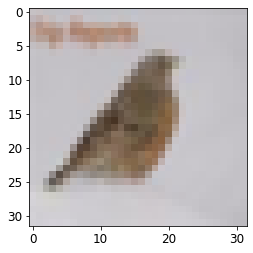

In [0]:
#playing
plt.figure(10)
img = plt.imshow(X_train[108])

Just For Fun

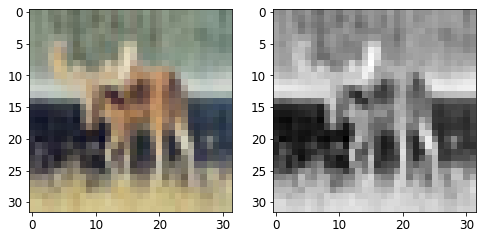

In [0]:
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

X_train_gray = grayscale(X_train)
X_test_gray = grayscale(X_test)

# now we have only one channel in the images
img_channels = 1

# plot a randomly chosen image
img = 28  #image number
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(X_train[img], interpolation='none')
plt.subplot(1, 2, 2)
plt.imshow(X_train_gray[img, :, :, 0], cmap=plt.get_cmap('gray'), interpolation='none')
plt.show()

In [0]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def get_classes_index_by_name(name):
  if name == 'airplane' : return 0
  if name == 'automobile' : return 1
  if name == 'bird' : return 2;
  if name == 'cat' : return 3;
  if name == 'deer' : return 4;
  if name == 'dog' : return 5;
  if name == 'frog' : return 6;
  if name == 'horse' : return 7;
  if name == 'ship' : return 8;
  if name == 'truck' : return 9;
  sys.exit("uknown classes")

In [0]:
def visualize_sample(X_train, y_train, classes, samples_per_class=7):
    """visualize some samples in the training datasets """
    num_classes = len(classes)
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y) # get all the indexes of cls
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs): # plot the image one by one
            plt_idx = i * num_classes + y + 1 # i*num_classes and y+1 determine the row and column respectively
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()

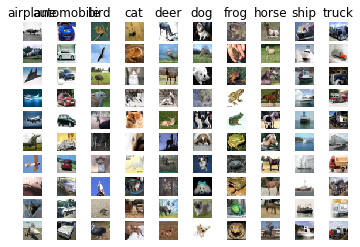

In [0]:
visualize_sample(X_train, y_train, classes, samples_per_class=10)

In [4]:
# As a sanity check, we print out th size of the training and test data dimenstion
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (50000, 32, 32, 3)
Train labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


Normalize the data before processing(Scaling request in the excercise)

In [0]:
# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [0]:
#Convert the X_train and X_test data from 4d array into 2d array:
nsamples, nx, ny,nz = X_train.shape
d2_X_train = X_train.reshape((nsamples,nx*ny*nz))
nsamples, nx, ny, nz = X_test.shape
d2_X_test = X_test.reshape((nsamples,nx*ny*nz))

In [0]:
#Train the Random Forest Classifier and capture the time taken to train the orginal model
#import library
from sklearn.ensemble import RandomForestClassifier
import time
#initial the model
rnd_clf = RandomForestClassifier()
start_time = time.time()
#Train the model
rnd_clf.fit(d2_X_train, y_train)
print("Time is taken by model:","— %s seconds —"% (time.time()-start_time))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Time is taken by model: — 280.03242921829224 seconds —


In [0]:
#Perfom the prediction on test data
y_predict = rnd_clf.predict(d2_X_test)

#Measure the accurancy of the Classifier
from sklearn.metrics import accuracy_score
print(f"Accuracy is {accuracy_score(y_predict, y_test) * 100}%")

Accuracy is 46.54%


use ***PCA** to reduce the dataset's dimensionality, with an explained variance ratio of 95%.

In [0]:
#Use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%
from sklearn.decomposition import PCA
import time
pca = PCA(n_components = .95) #This will insure that 95% variance is covered
time1=time.time()
X_train_pca = pca.fit_transform(d2_X_train)
print("PCA took {:.1f}s.".format(time.time() - time1))

#Verify the redued shape before we start training new model
#print(f"X_train shape is {d2_X_train.shape} and X_train_reduced shape is {X_train_reduced.shape}")
print(f"X_train shape is {d2_X_train.shape} and X_train_pca shape is {X_train_pca.shape}")

PCA took 75.5s.
X_train shape is (50000, 3072) and X_train_pca shape is (50000, 217)


Train the dimensionality reduced model with **Random Forest**, and calculating the time. 

In [0]:
start_time2 = time.time() 
rnd_clf.fit(X_train_pca, y_train) #Train the model 
print("Time is taken by model:","— %s seconds —"% (time.time()-start_time2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Time is taken by model: — 121.14815711975098 seconds —


After dimensionality reduced by PCA, train data with Random Forest took much less time -- was 280 seconds, now it's only 121 seconds.

In [0]:
X_test_reduced = pca.transform(d2_X_test) #Reduce the dimensionality first
y_predict2 = rnd_clf.predict(X_test_reduced) #Predic the values using Model
print(f"Accuracy is {accuracy_score(y_predict2, y_test)* 100} %") #Print the accuracy

Accuracy is 44.14 %


However the Accuracy dropped a little bit. 

Now we'll use **t-SNE** to reduce dimensionality down to 2D so we can plot the dataset. Current dimension is 3072

In [0]:
#Dimensionality reduction on the full 50,000 images takes a very long time, so we are doing this on a random subset of 10,000 images:
import numpy as np 
np.random.seed(42)

train_set = 10000 
idx = np.random.permutation(50000)[:train_set] 
X = d2_X_train[idx] 
y = y_train[idx]
print(f"Length of the X : {X.shape}, Length of y is : {y.shape}")

from sklearn.manifold import TSNE 

t0 = time.time()
tsne_red = TSNE(n_components=2, random_state=42) 
X_reduced = tsne_red.fit_transform(X)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))

Length of the X : (10000, 3072), Length of y is : (10000, 1)
t-SNE took 859.0s.


Train the dimensionality reduced model （used t-SNE）） with Random Forest, and calculating the time. 

In [0]:
start_time3 = time.time() 
rnd_clf.fit(X_reduced, y) #Train the model 
print("Time is taken by model:","— %s seconds —"% (time.time()-start_time3))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Time is taken by model: — 1.993208885192871 seconds —


In [0]:
X_test_reduced2 =tsne_red.fit_transform(d2_X_test) #Reduce the dimensionality first
y_predict3 = rnd_clf.predict(X_test_reduced2) #Predic the values using Model
print(f"Accuracy is {accuracy_score(y_predict3, y_test)* 100} %") #Print the accuracy

Accuracy is 12.889999999999999 %


WOW t-SNE took a super long time to reduce dimensionality: 858.8 seconds!! And the accuracy with the t-SNE processed data is super low, 12.9 % accuracy. 
Compare to t-SNE, PCA is much faster, and has higher accuracy in this case. However 43% is not that high either. I'll study more, and try to figure out better methods to use. 




**Binary classifiers**

**Convert y_train data from 2d array to 1d array. 
In order to draw ROC curves**

In [28]:
d1_y_train = y_train.ravel()

y_train_H = (d1_y_train == get_classes_index_by_name('horse'))
y_test_H = (y_test == get_classes_index_by_name('horse'))

y_train_H2 = (y_train == get_classes_index_by_name('horse'))
#y_test_H = (y_test == get_classes_index_by_name('horse'))

y_train_H
y_train_H2
#d2_X_train[get_classes_index_by_name('horse')]

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [8]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(d2_X_train, y_train_H)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
some_digit = d2_X_train[get_classes_index_by_name('horse')]
sgd_clf.predict([some_digit])

array([ True])

**Cross Validation Score**

In [0]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, d2_X_train, y_train_H, cv=3, scoring="accuracy")

array([0.90226195, 0.89956201, 0.8876155 ])

### **K-Fold**



In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_H):
    clone_clf = clone(sgd_clf)
    X_train_folds =d2_X_train[train_index]
    y_train_folds = y_train_H[train_index]
    X_test_fold =d2_X_train[test_index]
    y_test_fold = y_train_H[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9022619547609048
0.8995620087598248
0.8876155046201848


The StraitifiedKFold class performs stratified smpling to produce folds that contain a representative ratio of each class. It counts the number of correct predictions and outputs the ratio of correct predictions. At each iteration the code creats a clone of the classifier, trains that clone on the training folds and make predictions on the test fold. Then it counts the number of correct predictions and output the ratio of correct predictions. 

K-fold cross validation means splitting the training set into K-folds, and we did 3 folds in this exercises. 

In [0]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [0]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, d2_X_train, y_train_H, cv=3, scoring="accuracy")

array([0.89878202, 0.89938201, 0.90183607])

Wow! Around 90% accuracy! This is simply because 10% of the images are horses, so if you always guess that an image is not horse, you will be right about 90% of the time. 

### **Confusion Matrix**

make predictions on the test set.
Just like the cross_val_score() function, cross_val_predict() performs ***K-fold cross-validation**, but instead of retruning the evaluation scores, it returns the predictions made on each test fold. 

In [0]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, d2_X_train, y_train_H, cv=3)

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_H, y_train_pred)

array([[43487,  1513],
       [ 3663,  1337]])

The first row of this matrix considers non-horse images: 43487 of them were correctly classified as non-horses (true negative); 1513 were wrongly classified as horses (false positive); The second row considers the images of 5s(positive class): 3663 were wrongly classified as non-horses(false negative); 1337 were correctly classified as horses (true positives); 

In [0]:
y_train_perfect_predictions = y_train_H  # pretend we reached perfection
confusion_matrix(y_train_H, y_train_perfect_predictions)

array([[45000,     0],
       [    0,  5000]])

In [0]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_H, y_train_pred)


0.4691228070175439

***Precision**

precision = TP/(TP + FP), it's the accuracy of the positive predictions. 

In [0]:
print("1337/(1337+1513) = ", 1337/(1337+1513) )

1337/(1337+1513) =  0.4691228070175439


***SENSITIVITY / Recall**

sensitivity = recall = TP/(TP+FN), it's the ratio of positive instances that are correctly detected by the classifier

In [0]:
recall_score(y_train_H, y_train_pred)

0.2674

In [0]:
print("1337/(1337+3663) = ", 1337/(1337+3663) )

1337/(1337+3663) =  0.2674


***SPECIFICITY**

Specificity = TN/(TN+FP), ture negative rate

In [0]:
print("Specificity = ", 43487/(43487+1513) )

Specificity =  0.9663777777777778


In [0]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([4.08976723])

In [0]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [0]:
y_some_digit_pred

array([ True])

In [0]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [0]:
y_scores = cross_val_predict(sgd_clf, d2_X_train, y_train_H, cv=3,
                             method="decision_function")

In [0]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_H, y_scores)

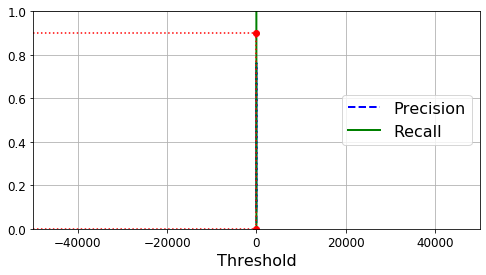

In [0]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.75)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
#save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

Something's wrong with this graph, have to fix it later. 

In [0]:
(y_train_pred == (y_scores > 0)).all()

True

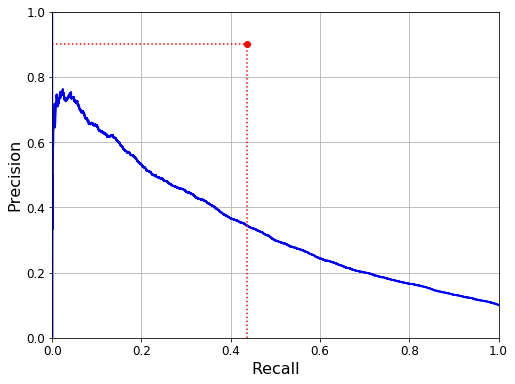

In [0]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
#save_fig("precision_vs_recall_plot")
plt.show()

### **ROC Curves**

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. 

***SGD Classifier's ROC Curve**

In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_H, y_scores)

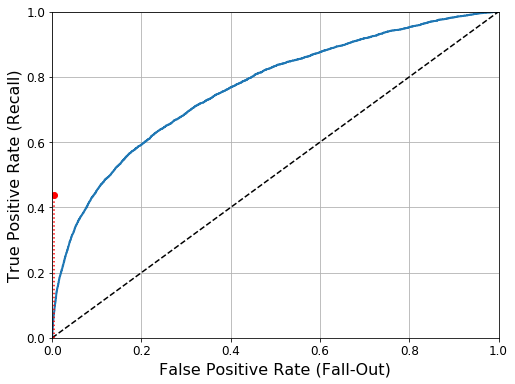

In [0]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
#save_fig("roc_curve_plot")                         # Not shown
plt.show()

In [0]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_H, y_scores)

0.7658821644444445

***Random Forest's ROC Curve**

In [0]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, d2_X_train, y_train_H, cv=3,
                                    method="predict_proba")

In [0]:
print(y_train_H)
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
print(y_scores_forest)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_H, y_scores_forest)

[False False False ... False False False]
[0.12 0.13 0.19 ... 0.05 0.07 0.25]


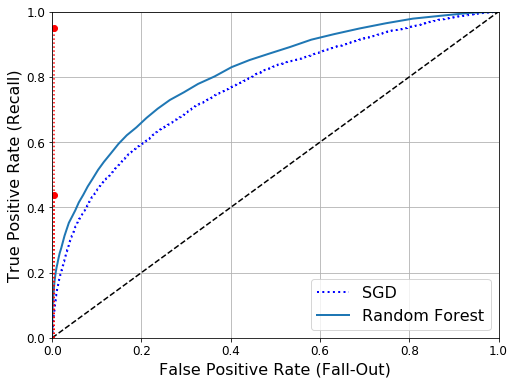

In [0]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()

As we can see, the RandomForestClassifier's ROC curve looks better than the SGDClassifier's ROC curve: It comes closer to the top-left coner.

In [0]:
roc_auc_score(y_train_H, y_scores_forest)

0.8101624666666667

For fun

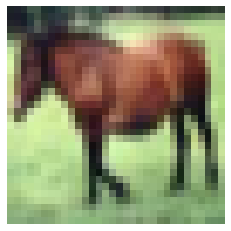

In [0]:
randomX = d2_X_train[get_classes_index_by_name('horse')]
randomX_image = randomX.reshape(32, 32,3)
plt.imshow(randomX_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

### **Multiclass classifiers**
**SVM**

We have already predited using Random Forest Above.
Now we are using SVM to predict, using PCA dimentionalisy-reduced data


In [29]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(d2_X_train[:1000], y_train_H2[:1000]) 
svm_clf.predict([some_digit])


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([False])

In [30]:
d2_X_train[0]

array([0.23137255, 0.24313726, 0.24705882, ..., 0.48235294, 0.36078432,
       0.28235295], dtype=float32)

In [31]:
y_scores_svm = svm_clf.decision_function([some_digit])
y_scores_svm

array([-0.9480374])

In [0]:
np.argmax(randomX_scores)

6

In [24]:
svm_clf.classes_

array([False,  True])

In [0]:
len(ovr_clf.estimators_)

10

In [0]:
sgd_clf.fit(d2_X_train, y_train)
sgd_clf.predict([some_digit])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([7], dtype=uint8)

In [0]:
sgd_clf.decision_function([some_digit])

array([[-2.22839275, -4.81084845, -2.07122744, -2.75403996, -0.47629739,
        -0.81657867, -3.58224055,  3.96315565, -5.31196064, -7.52558589]])

In [0]:
cross_val_score(sgd_clf, d2_X_train, y_train, cv=3, scoring="accuracy")

In [0]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In this Project

1, I used PCA, t-SNE to reduce dimensionalities and compared the results. In conclusion, PCA is much faster and have a much higher accuracy in this case. 

2, I have trained data with Random Forest, and SGD Classifiers and drew ROC curves for both classifiers for comparison. As a result, Random Forest is the better classifier with 81% ROC AUC. I have converted the y_train data from 2d array to 1 day array in order to draw ROC curve for Random Forest. 

3,I also did K-fold cross-validation with 2 different kinds of binary classifiers. Never5Classifier and SGDClassifier both have around 90% accuracy. This is simply because 10% of the images are horses, so if you always guess that an image is not horse, you will be right about 90% of the time.

4, Lastly I did the confusion matrix under SGD Classifier, and calculated the sensitivity(recall) and specificity. 

However, my SVM is not done, I have tried multiple times,and it ran forever every single time. Thus, I believe SVM is not a very good classifier in this case, as it's very time consuming. In conclusion, Random Forest is the best classifier in this project. 
 
